In [341]:
! pip install keras
! pip install tensorflow

# Rete Neurale

In [342]:
import pandas as pd
import numpy as np
import keras
import warnings

warnings.filterwarnings('ignore')

In [343]:
dataset = pd.read_csv("./Dataset/Brain Tumor.csv", index_col=0)
dataset["Class"] = dataset["Class"].astype("category")
dataset = dataset[['Mean', 'Entropy', 'Skewness', 'Contrast', 'Correlation', 'Class']]
dataset.head(10)

,Mean,Entropy,Skewness,Contrast,Correlation,Class
Image,,,,,,
Image1,6.535339,0.109059,4.276477,98.613971,0.981939,0
Image2,8.749969,0.266538,3.718116,63.858816,0.988834,0
Image3,7.341095,0.001467,5.061750,81.867206,0.978014,1
Image4,5.958145,0.001477,5.677977,151.229741,0.964189,1
Image5,7.315231,0.146761,4.283221,174.988756,0.972789,0
Image6,7.524109,0.214086,3.729886,105.077882,0.976485,0
Image7,12.304413,0.128833,2.930095,115.203118,0.974745,0
Image8,15.929474,0.107658,2.484002,94.874288,0.976774,0
Image9,19.921616,0.094975,2.129173,93.818920,0.974310,0


In [344]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = dataset['Class']
X = dataset.drop(['Class'], axis=1)

columns_name = X.columns

X[columns_name] = scaler.fit_transform(X)

X.head()

,Mean,Entropy,Skewness,Contrast,Correlation
Image,,,,,
Image1,-0.515700,0.504650,0.067855,-0.268050,1.000713
Image2,-0.129018,2.746050,-0.150204,-0.585492,1.264377
Image3,-0.375013,-1.026708,0.374531,-0.421010,0.850636
Image4,-0.616481,-1.026561,0.615188,0.212525,0.322041
Image5,-0.379529,1.041256,0.070489,0.429532,0.650854


In [345]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dataset:\n\t-Negative", round((y.value_counts()[0]/y.shape[0]) * 100, 2),
      "%\n\t-Positive", round((y.value_counts()[1]/y.shape[0]) * 100, 2), "%")
print("Train data:\n\t- Negative", round((y_train.value_counts()[0] / y_train.shape[0]) * 100, 2),
      "%\n\t- Positive", round((y_train.value_counts()[1] / y_train.shape[0]) * 100, 2), "%")

Dataset:
	-Negative 55.26 %
	-Positive 44.74 %
Train data:
	- Negative 55.27 %
	- Positive 44.73 %


## Selezione degli iperparametri

In [346]:
from keras.models import Sequential
from keras.layers import Dense
from itertools import product

In [347]:
def create_model(units=[6, 6], activation='relu', opt='adam', metric='accuracy', input_layer_size=5):
  model = Sequential()

  model.add(Dense(units=units[0], input_shape=(input_layer_size,), activation=activation))
  model.add(Dense(units=units[1], activation=activation))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metric])

  return model

In [348]:
# Data preparation
X_cross_val = pd.DataFrame(data = X_train, columns = columns_name)
Y_cross_val = pd.DataFrame(data = y_train, columns = ['Class'])

Y_cross_val = (Y_cross_val.reset_index()).drop(['Image'], axis=1)
X_cross_val = (X_cross_val.reset_index()).drop(['Image'], axis=1)

In [349]:
# Param
units = [5, 10, 15]
activation = ['relu', 'sigmoid', 'softmax', 'leaky_relu', 'elu']
optimizer = ['sgd', 'adam']
batch_size = [10, 30, 50]

param_combinations = list(product(units, units, activation, optimizer, batch_size))

In [350]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import time

In [351]:
k = 5 # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True)

# Create a history of model train
performance = dict()

# Iterate over combination
# for i, (u1, u2, act, opt, batch) in enumerate(tqdm(param_combinations)):
#   # Setup dictornary
#   performance[i] = dict()
#   performance[i]['param'] = ([u1, u2], act, opt, batch)
#   performance[i]['results'] = []
#   performance[i]['time'] = []

#   # Create model
#   model = create_model(units=[u1, u2], activation=act, opt=opt)

#   # Train model
#   for train_idx, test_idx in skf.split(X_cross_val, Y_cross_val):
#     X_val_train, X_val_test = X_cross_val[X_cross_val.index.isin(train_idx)], X_cross_val[X_cross_val.index.isin(test_idx)]
#     y_val_train, y_val_test = Y_cross_val[Y_cross_val.index.isin(train_idx)], Y_cross_val[Y_cross_val.index.isin(test_idx)]

#     start = time.time()

#     model.fit(X_val_train, y_val_train, epochs=50, batch_size=batch, verbose=0)

#     end = time.time()

#     # Evaluate the model on the test set
#     score = model.evaluate(X_val_test, y_val_test, verbose=0)
#     performance[i]['results'].append(score[1])
#     performance[i]['time'].append(end - start)

### Valutazione dei risulati per la selezione degli iperparametri

In [352]:
import scipy.stats as st
import json

In [353]:
with open("./neuralnetwork.json", "w") as outfile:
  json.dump(performance, outfile)

In [354]:
dict_keys = list(performance.keys())

for k in dict_keys:
  accuracy = performance[k]['results']
  print(st.t.interval(confidence=0.90, df=len(accuracy)-1, loc=np.mean(accuracy), scale=st.sem(accuracy)))

## Creazione della rete neurale

In [355]:
# Get the best model
best_model = ([10, 5], 'leaky_relu', 'adam', 30)

# Create the best model
model = create_model(units=best_model[0], activation=best_model[1], opt=best_model[2], input_layer_size=X_train.shape[1])

In [356]:
model.fit(X_train, y_train, epochs=300, batch_size=best_model[3], verbose=0)

## Valutazione della rete neurale

In [357]:
def predict(model, X_test):
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred > 0.3, 1, 0).flatten()
    return y_pred

In [358]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [359]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03268047422170639
Test accuracy: 0.9893758296966553


In [360]:
# Valuta il modello utilizzando i dati di test
y_pred = predict(model, X_test)

accuracy_train_test = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

24/24 [==============================] - 0s 2ms/step
Accuracy: 0.9867197875166003
Precision: 0.9823008849557522
Recall: 0.9881305637982196
F1-score: 0.9852071005917159


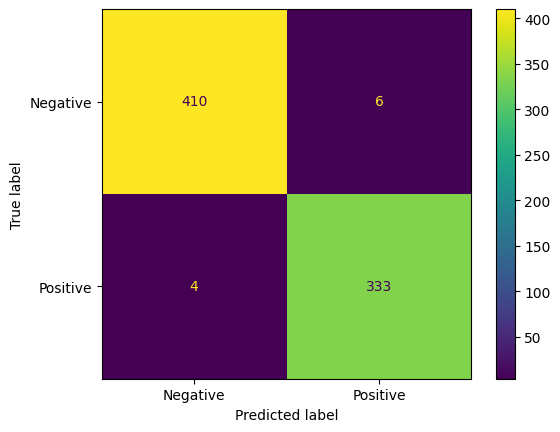

In [361]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

In [362]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       414
           1       0.99      0.98      0.99       339

    accuracy                           0.99       753
   macro avg       0.99      0.99      0.99       753
weighted avg       0.99      0.99      0.99       753



### Curva ROC

24/24 [==============================] - 0s 2ms/step


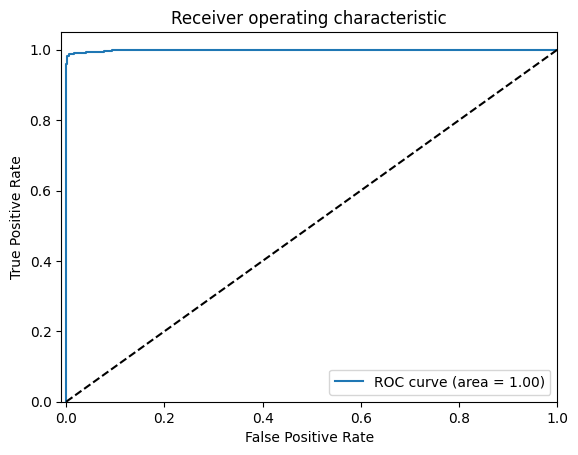

In [363]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


y_pred_prob = model.predict(X_test).ravel()

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC della curva ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 10-fold cross validation

In [364]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

In [365]:
accuracy_stratified = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = create_model(units=best_model[0], activation=best_model[1], opt=best_model[2], input_layer_size=X_train.shape[1])
        model.fit(X_train, y_train, epochs=300, batch_size=best_model[3], verbose=0)

        y_pred_valid = predict(model, X_valid)
        accuracy_stratified.append(accuracy_score(y_valid, y_pred_valid))

12/12 [==============================] - 0s 3ms/step


In [366]:
st.t.interval(confidence=0.90, df=len(accuracy_stratified)-1, loc=np.mean(accuracy_stratified), scale=st.sem(accuracy_stratified))

(0.9811900988166119, 0.9895701020976609)